## LSTM 模型

#### 选取特征列

使用 'Adj Close', 'Volume', 'FedRate', 'CPI', 'RSI', 'Confirmed' 进行预测

In [3]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 股票
ticker = 'TSLA'
# 处理每个股票的数据
input_file = f'{ticker}_data.csv'
# 检查 MPS 或 CPU 可用性
if torch.backends.mps.is_available():
    print('support')
    device = torch.device("mps")
else:
    print('not support')
    device = torch.device("cpu")

data = pd.read_csv(input_file, parse_dates=['Date'])
# 假设 data 是一个包含股票数据的 DataFrame
# 计算RSI指标
data['RSI'] = 100 - (100 / (1 + data['Adj Close'].pct_change().rolling(window=14).mean() / data['Adj Close'].pct_change().rolling(window=14).std()))

# 选择需要归一化的列
columns_to_normalize = ['Adj Close', 'Volume', 'FedRate', 'CPI', 'RSI']


# 移除NaN值
data = data.dropna()

# 初始化 Min-Max 归一化
scaler = MinMaxScaler()

# 对选定列进行归一化
data['origin_adj'] = data['Adj Close']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

support


#### 构建模型

In [27]:
# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x,)
        # out = self.dropout(out[:, -1, :])
        out = self.fc(out[:,-1,:])
        return out
    

# 损失函数
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

#### 训练模型

In [28]:
# 准备训练数据
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # 预测Adj Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

 # 前  80% 的数据进行模型训练
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
print(len(test_data))

seq_length = 10
train_values = train_data[columns_to_normalize].values
x_train, y_train = create_sequences(train_values, seq_length)
print(x_train.shape, y_train.shape)
test_values = test_data[columns_to_normalize].values
x_test, y_test = create_sequences(test_values, seq_length)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(-1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(-1)

print(f"x_train_tensor shape before: {x_train_tensor.shape}")
print(f"y_test_tensor shape before: {y_test_tensor.shape}")

data_values = data[columns_to_normalize].values

# 创建数据集和数据加载器
batch_size = 64  # 批量大小
dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

295
(1168, 10, 5) (1168,)
x_train_tensor shape before: torch.Size([1168, 10, 5])
y_test_tensor shape before: torch.Size([285, 1])


In [61]:
# 初始化模型、损失函数和优化器
input_size = len(columns_to_normalize)
hidden_size = 50  # 隐藏层数量
num_layers = 3  #  LSTM 层数
dropout_prob = 0.1  # Dropout 概率
learning_rate = 0.008  # 学习率

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
num_epochs = 500  # 训练轮数，理论上最好能保持训练集的误差和测试集误差接近
best_rmse = float('inf')  # 初始化最好的 RMSE 为正无穷大
best_model_path = f'{ticker}_best_lstm_model.pth'  # 模型保存路径
model.train()

train_losses = [] # 用以绘制损失函数图像
test_losses = []


for epoch in range(num_epochs):
    ## 训练集误差
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        
        loss = criterion(outputs, y_batch)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss / len(train_loader) 
    train_losses.append(train_loss)
    
    # 测试集手动计算误差
    model.eval()
    with torch.no_grad():
        pred_y = model(x_test_tensor)
        rmse = criterion(pred_y, y_test_tensor)
    test_losses.append(rmse.item())

    # 保存最佳模型
    if rmse.item() < best_rmse:
        best_rmse = rmse.item()
        torch.save(model.state_dict(), best_model_path)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} Epoch [{epoch+1}/{num_epochs}], test Loss: {rmse.item():.4f}')

Epoch [1/500], Loss: 0.1135 Epoch [1/500], test Loss: 0.4500
Epoch [2/500], Loss: 0.1011 Epoch [2/500], test Loss: 0.3862
Epoch [3/500], Loss: 0.0769 Epoch [3/500], test Loss: 0.3661
Epoch [4/500], Loss: 0.0552 Epoch [4/500], test Loss: 0.3648
Epoch [5/500], Loss: 0.0535 Epoch [5/500], test Loss: 0.3619
Epoch [6/500], Loss: 0.0550 Epoch [6/500], test Loss: 0.3548
Epoch [7/500], Loss: 0.0978 Epoch [7/500], test Loss: 0.3464
Epoch [8/500], Loss: 0.0488 Epoch [8/500], test Loss: 0.3099
Epoch [9/500], Loss: 0.0481 Epoch [9/500], test Loss: 0.3232
Epoch [10/500], Loss: 0.0587 Epoch [10/500], test Loss: 0.3195
Epoch [11/500], Loss: 0.0563 Epoch [11/500], test Loss: 0.2762
Epoch [12/500], Loss: 0.0547 Epoch [12/500], test Loss: 0.3061
Epoch [13/500], Loss: 0.0541 Epoch [13/500], test Loss: 0.2966
Epoch [14/500], Loss: 0.0406 Epoch [14/500], test Loss: 0.2884
Epoch [15/500], Loss: 0.0532 Epoch [15/500], test Loss: 0.2730
Epoch [16/500], Loss: 0.0413 Epoch [16/500], test Loss: 0.2754
Epoch [17/

#### 预测股价

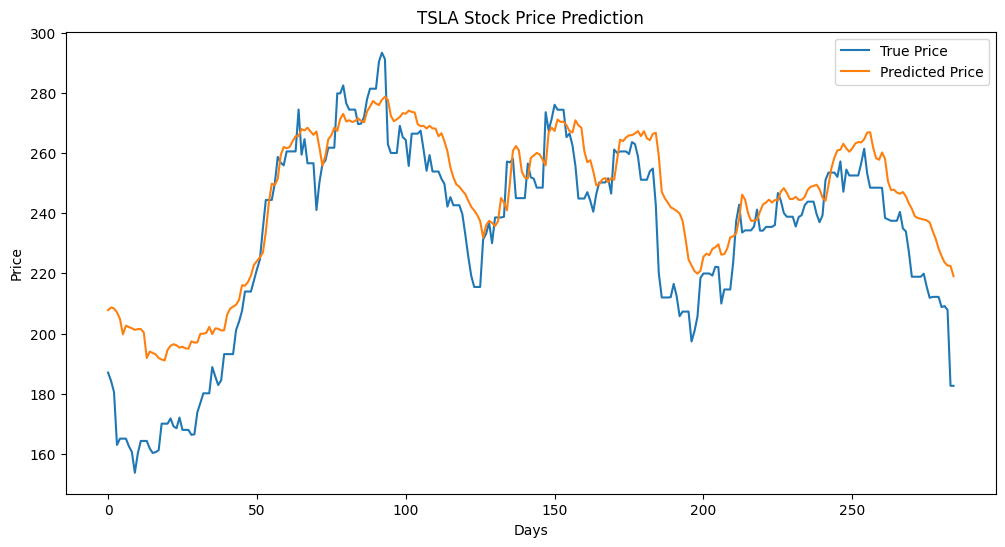

RMSE: 16.2561


In [62]:
# 加载最佳模型
model.load_state_dict(torch.load(best_model_path))
model.eval()
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device)
    if len(x_test_tensor.shape) == 2:
        x_test_tensor = x_test_tensor.unsqueeze(-1) 
    predictions = model(x_test_tensor).cpu().numpy()

# 只反归一化 Adj Close 列
# 获取 scaler 的参数
scaler_min = scaler.data_min_[0]  # 归一化前的最小值
scaler_max = scaler.data_max_[0]  # 归一化前的最大值

# 反归一化
predictions_denorm = predictions * (scaler_max - scaler_min) + scaler_min
y_test_denorm = y_test * (scaler_max - scaler_min) + scaler_min

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='True Price')
plt.plot(predictions_denorm, label='Predicted Price')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

# 计算评价指标
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test_denorm, predictions_denorm, squared=False)
print(f"RMSE: {rmse:.4f}")


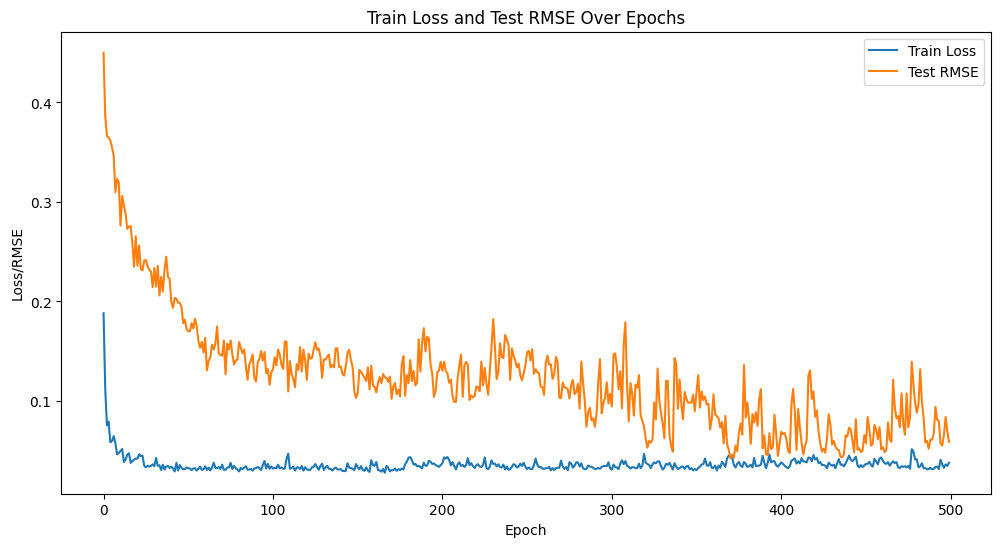

In [63]:
# 绘制训练损失和验证损失图像
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test RMSE')
plt.legend()
plt.title('Train Loss and Test RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss/RMSE')
plt.show()

## ARIMA 模型

/var/folders/9n/bcfhtg5541d9rk5jnjx5j2w80000gn/T/ipykernel_74814/4124983021.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[target_col].fillna(method='ffill', inplace=True)
/var/folders/9n/bcfhtg5541d9rk5jnjx5j2w80000gn/T/ipykernel_74814/4124983021.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[target_col].fillna(method='ffill', inplace=True)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:3

ADF Statistic: -2.3429669175298478
p-value: 0.15848436767320467
Critical Values:
   1%: -3.434812378381713
   5%: -2.863510846577674
   10%: -2.5678192598690317
p-value 大于 0.05，数据可能是非平稳的。
ADF 统计量大于 10% 显著性水平的临界值，数据可能是非平稳的。
ADF Statistic: -9.022217921641687
p-value: 5.734556124976907e-15
Critical Values:
   1%: -3.434812378381713
   5%: -2.863510846577674
   10%: -2.5678192598690317
p-value 小于 0.05，，数据是平稳的。
ADF 统计量小于 1% 显著性水平的临界值，数据是平稳的。


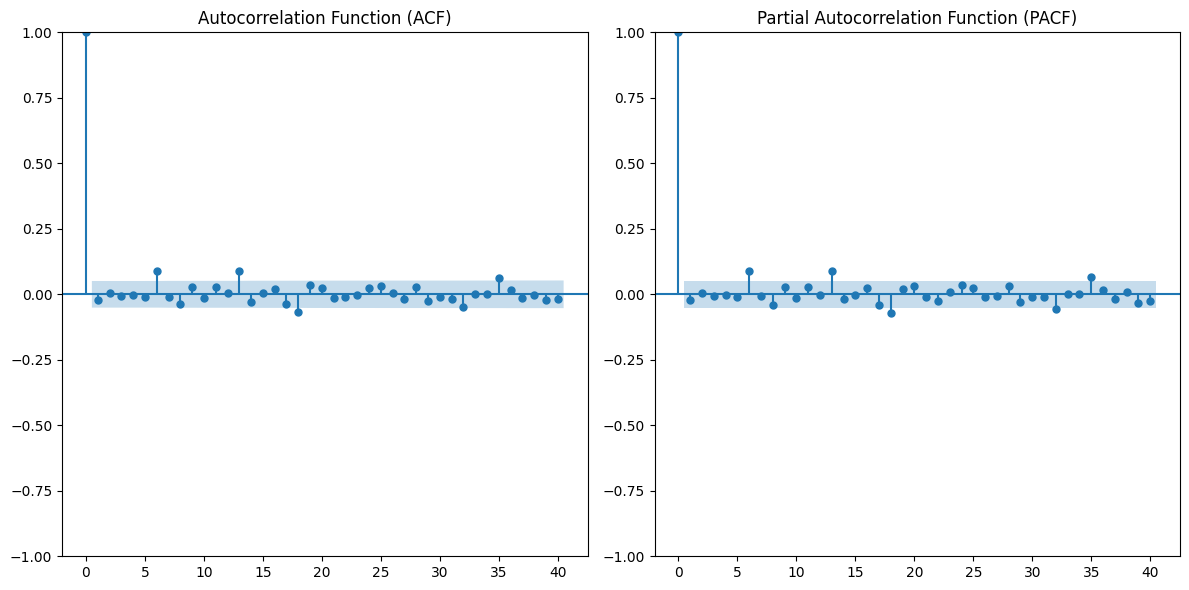

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



def adf_test(series):
    result = adfuller(series.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    if result[1] < 0.05:
        print("p-value 小于 0.05，，数据是平稳的。")
    else:
        print("p-value 大于 0.05，数据可能是非平稳的。")
    
    if result[0] < result[4]['1%']:
        print("ADF 统计量小于 1% 显著性水平的临界值，数据是平稳的。")
    elif result[0] < result[4]['5%']:
        print("ADF 统计量小于 5% 显著性水平的临界值，数据是平稳的。")
    elif result[0] < result[4]['10%']:
        print("ADF 统计量小于 10% 显著性水平的临界值，数据是平稳的。")
    else:
        print("ADF 统计量大于 10% 显著性水平的临界值，数据可能是非平稳的。")

# 执行 ADF 检验



data = pd.read_csv(input_file, parse_dates=['Date'])

# 处理日期索引
data.set_index('Date', inplace=True)

# 选择目标变量，这里假设是 'Adj Close'
target_col = 'Adj Close'

# 填充缺失值（如果有）
data[target_col].fillna(method='ffill', inplace=True)

adf_test(data[target_col])


# 差分使其平稳
diff_series = data[target_col].diff().dropna()

# 再次检查差分后的数据的平稳性
adf_test(diff_series)

# 绘制 ACF 和 PACF 图
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(diff_series, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plot_pacf(diff_series, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

RMSE: 48.6660


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


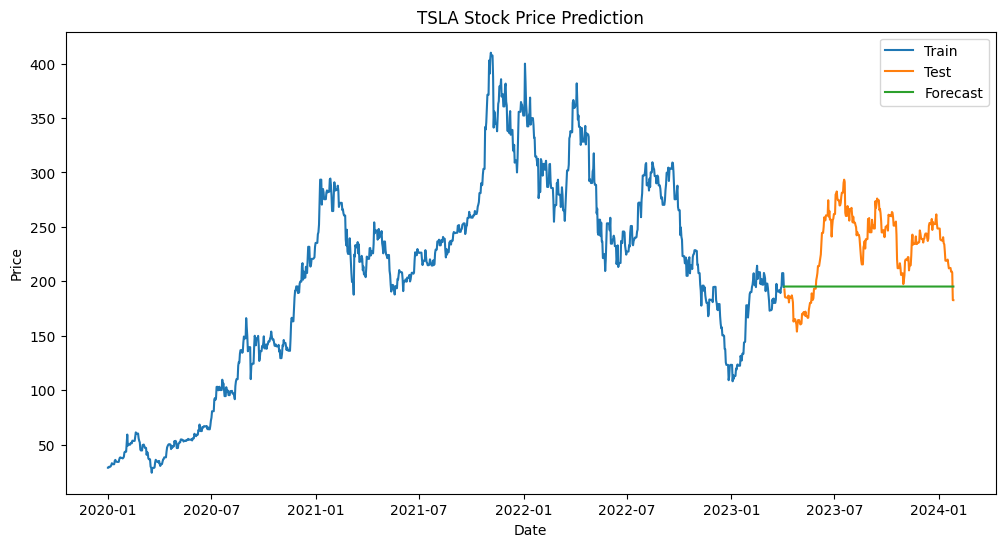

In [5]:
# 切分训练集和测试集

train_len =  int(len(data[target_col]) * 0.8)

train_data = data[target_col][:train_len]
test_data = data[target_col][train_len:]




# ARIMA 模型参数 (p, d, q)
p, d, q = 1, 1, 1


# 训练 ARIMA 模型
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# 预测
forecast_steps = len(test_data)
forecast = model_fit.forecast(steps=forecast_steps)

# 将预测结果与实际值进行比较

# 计算 RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f'RMSE: {rmse:.4f}')

# 可视化预测结果
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()